In [8]:
import numpy as np
import pandas as pd
import pickle, csv
import os

from keras.models import Sequential, load_model, Model
from keras.layers import LSTM, Dense, Dropout, Input, concatenate, Flatten, Reshape,MaxPooling2D, Conv2D, TimeDistributed
from keras import regularizers
from keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow.keras.backend as K
from skimage.transform import resize
from tensorflow.keras import layers, models


from matplotlib import pyplot as plt
from matplotlib import style
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

import tensorflow.keras.backend as K
K.clear_session()

In [9]:
# Load powerprice data and format it
df_powerprice = pd.read_csv("data/PowerPrice.csv")
df_powerprice["Time"] = pd.to_datetime(df_powerprice["Time"], infer_datetime_format=True)
df_powerprice = df_powerprice.drop(columns=["Time"])
df_powerprice

,DayAhead,Spot,REBAP
0,2.83200,3.688,-4.566
1,2.37575,4.245,-13.964
2,1.91950,3.161,0.345
3,1.46325,1.664,3.048
4,1.00700,3.110,-6.679
...,...,...,...
35035,3.77625,3.342,4.856
35036,3.73900,4.425,8.561
35037,3.70175,2.473,6.076
35038,3.66450,3.241,11.797


In [10]:
# Load spatial data and format it
datasets = []
for filename in os.listdir("data/Spatial"):
    if filename.endswith(".pickle"):
        with open(os.path.join("data/Spatial", filename), "rb") as file:
            data = pickle.load(file)
            if data.shape == (100, 35040):
                datasets.append(data)
                print(filename)
            else:
                print(f"Skipping {filename}: unexpected shape {data.shape}")

biogas_kw_2019.pickle
brown_coal_kw_2019.pickle
completed_solar_kw_2019.pickle
completed_wind_onshore_kw_2019.pickle
demand_kw_2019.pickle
hard_coal_kw_2019.pickle
nuclear_kw_2019.pickle
oil_kw_2019.pickle
water_laufwasser_kw_2019.pickle
water_pumpspeicher_PB_kw_2019.pickle
water_pumpspeicher_TB_kw_2019.pickle
water_speicherwasser_kw_2019.pickle
wind_offshore_kw_2019.pickle


In [11]:
# Convert the list of arrays to a 3D array
spatial_data = np.stack(datasets, axis=0)

spatial_data = spatial_data.reshape((spatial_data.shape[0], spatial_data.shape[1], spatial_data.shape[2]))

# transpose the second and third dimensions to get shape (13, 35040, 100)
spatial_data = spatial_data.transpose((0, 1, 2))

spatial_data.shape

(13, 100, 35040)

In [12]:
# Load mask and reshape to match desired output shape
mask = pd.read_csv("germany/mask.csv", header=None).values
#mask = mask_df.values.reshape((40, 40, 1))

mask.shape

(30, 30)

In [13]:
spatial_data.shape

(13, 100, 35040)

In [14]:
image_all = np.zeros((35040, 30, 30, 13))
for j in range(spatial_data.shape[2]):
    for i in range(spatial_data.shape[0]):
        image = np.zeros((30, 30))
        for s in range(spatial_data.shape[1]):
            image[mask == s] = spatial_data[i,s,j]
        #print(i)
        image_all[j, :, :, i] = image

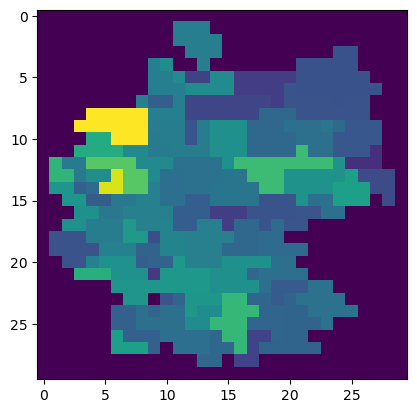

In [15]:
plt.imshow(image_all[35030,:,:,4])
plt.show()

In [16]:
image_all.shape

(35040, 30, 30, 13)

In [17]:
#input_2 = df_powerprice["DayAhead"].values.reshape((-1, 4))
#input_2.shape

In [42]:
output = df_powerprice["Spot"].values

scaler = MinMaxScaler()
output = scaler.fit_transform(output.reshape(-1, 1))

output

array([[0.34239157],
       [0.34917003],
       [0.33597819],
       ...,
       [0.32760551],
       [0.33695176],
       [0.33731685]])

In [19]:
def split_datasets(df, df2, window_size, look_ahead):
    X = []
    y = []
    for i in range(len(df) - window_size - look_ahead + 1):
        row = df[i:i+window_size, :, :, :]
        X.append(row)
        label = df2[i+window_size+look_ahead-1]
        y.append(label)
    return np.array(X), np.array(y)

In [20]:
window_size = 4
look_ahead = 1
X, y = split_datasets(image_all, output, window_size=window_size, look_ahead=look_ahead)

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (35036, 4, 30, 30, 13), y shape: (35036, 1)


In [21]:
# Reshape the input array to a 2D array
input_2d = X.reshape(-1, X.shape[-1])

# Scale the array using MinMaxScaler
scaler = MinMaxScaler()
input_scaled = scaler.fit_transform(input_2d)

# Reshape the scaled array back to the original shape
X = input_scaled.reshape(X.shape)

print("Scaled X shape:", X.shape)

Scaled X shape: (35036, 4, 30, 30, 13)


In [22]:
# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=30)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (17167, 4, 30, 30, 13)
y_train shape: (17167, 1)
X_val shape: (7358, 4, 30, 30, 13)
y_val shape: (7358, 1)
X_test shape: (10511, 4, 30, 30, 13)
y_test shape: (10511, 1)


In [23]:
time_steps = 4
width = 30
height = 30
channel = 13

# Define the input layer
input_layer = Input(shape=(time_steps, width, height, channel))

# Define the convolutional layers
cnn1 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')
cnn2 = MaxPooling2D(pool_size=(2, 2))
cnn3 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')
cnn4 = MaxPooling2D(pool_size=(2, 2))

# Apply TimeDistributed to the convolutional layers
td_cnn1 = TimeDistributed(cnn1)(input_layer)
td_cnn2 = TimeDistributed(cnn2)(td_cnn1)
td_cnn3 = TimeDistributed(cnn3)(td_cnn2)
td_cnn4 = TimeDistributed(cnn4)(td_cnn3)

# Reshape the output of the convolutional layers
reshaped = Reshape((-1, 6*6*32))(td_cnn4)

# Apply TimeDistributed Dense layer
td_fcnn = TimeDistributed(Dense(10, activation='relu', name='output'))(reshaped)

# Apply LSTM layer
lstm_output = LSTM(1, name='lstm1_1')(td_fcnn)

# Create the model
model = Model(inputs=input_layer, outputs=lstm_output)

# Print the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 30, 30, 13)]   0         
                                                                 
 time_distributed (TimeDistr  (None, 4, 28, 28, 16)    1888      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 4, 14, 14, 16)    0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 4, 12, 12, 32)    4640      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 4, 6, 6, 32)      0         
 tributed)                                                   

In [24]:
# Compile the model with an appropriate optimizer and loss function

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [25]:
# Define callbacks for early stopping and checkpoint saving
es = EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True)

In [26]:
cp = ModelCheckpoint(filepath="training/model-website/model4.h5", 
                      save_best_only=True,
                      monitor='val_loss', 
                      mode='min', 
                      save_weights_only=False, 
                      verbose=1)

In [27]:
# Fit the model on the training data
history = model.fit(X_train, y_train, batch_size=32, epochs=1000, validation_data=(X_val, y_val), callbacks=[cp, es])

Epoch 1/1000
533/537 [============================>.] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0434
Epoch 1: val_loss improved from inf to 0.00039, saving model to training/model-website\model4.h5
537/537 [==============================] - 8s 10ms/step - loss: 0.0019 - root_mean_squared_error: 0.0432 - val_loss: 3.8687e-04 - val_root_mean_squared_error: 0.0197
Epoch 2/1000
533/537 [============================>.] - ETA: 0s - loss: 3.5863e-04 - root_mean_squared_error: 0.0189
Epoch 2: val_loss improved from 0.00039 to 0.00033, saving model to training/model-website\model4.h5
537/537 [==============================] - 5s 9ms/step - loss: 3.5778e-04 - root_mean_squared_error: 0.0189 - val_loss: 3.3068e-04 - val_root_mean_squared_error: 0.0182
Epoch 3/1000
533/537 [============================>.] - ETA: 0s - loss: 3.1419e-04 - root_mean_squared_error: 0.0177
Epoch 3: val_loss improved from 0.00033 to 0.00029, saving model to training/model-website\model4.h5
537/537 [==========

Epoch 23/1000
534/537 [============================>.] - ETA: 0s - loss: 2.1017e-04 - root_mean_squared_error: 0.0145
Epoch 23: val_loss improved from 0.00020 to 0.00020, saving model to training/model-website\model4.h5
537/537 [==============================] - 5s 9ms/step - loss: 2.0955e-04 - root_mean_squared_error: 0.0145 - val_loss: 2.0038e-04 - val_root_mean_squared_error: 0.0142
Epoch 24/1000
530/537 [============================>.] - ETA: 0s - loss: 2.0508e-04 - root_mean_squared_error: 0.0143
Epoch 24: val_loss improved from 0.00020 to 0.00020, saving model to training/model-website\model4.h5
537/537 [==============================] - 5s 9ms/step - loss: 2.0407e-04 - root_mean_squared_error: 0.0143 - val_loss: 1.9941e-04 - val_root_mean_squared_error: 0.0141
Epoch 25/1000
534/537 [============================>.] - ETA: 0s - loss: 2.0392e-04 - root_mean_squared_error: 0.0143
Epoch 25: val_loss improved from 0.00020 to 0.00020, saving model to training/model-website\model4.h5
53

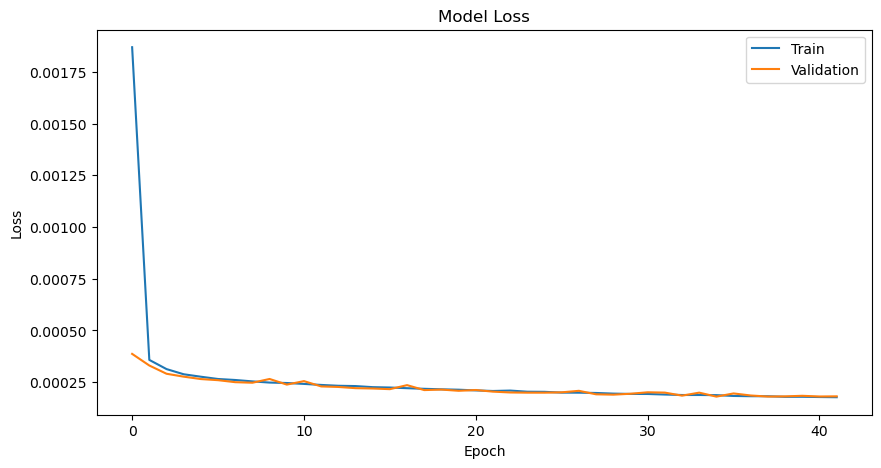

In [37]:
#Plot the training and validation loss

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

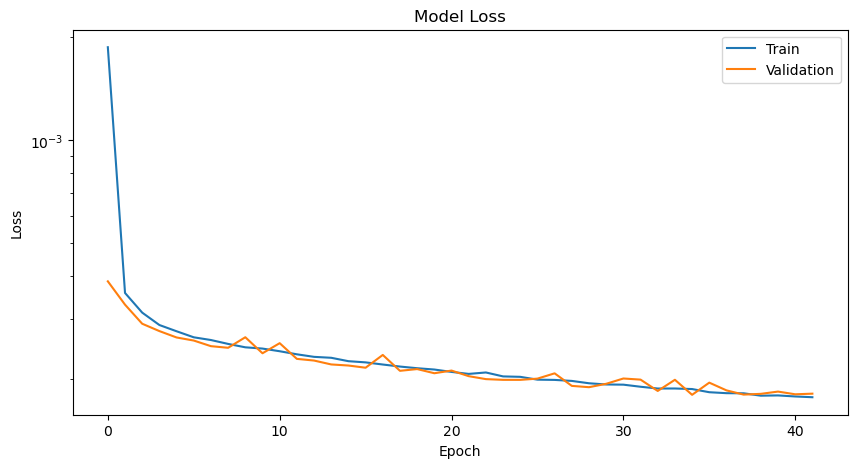

In [52]:
# Plot the training and validation loss on a logarithmic scale
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.yscale('log')  # Set the y-axis scale to logarithmic
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


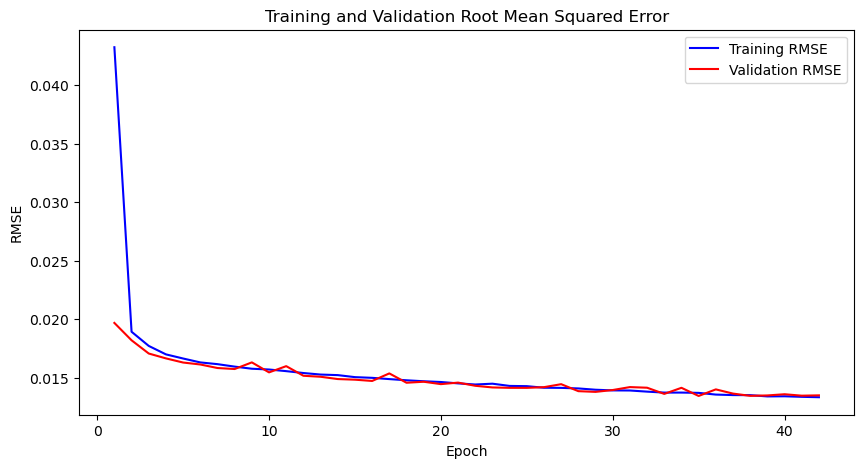

In [30]:
# Get the training and validation accuracy values from the history object
train_acc = history.history['root_mean_squared_error']
val_acc = history.history['val_root_mean_squared_error']

# Create a plot of training and validation accuracy
epochs = range(1, len(train_acc) + 1)
plt.figure(figsize=(10,5))
plt.plot(epochs, train_acc, 'b', label='Training RMSE')
plt.plot(epochs, val_acc, 'r', label='Validation RMSE')
plt.title('Training and Validation Root Mean Squared Error')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [31]:
# After training, print actual and predicted values for the validation data
y_val_pred = model.predict(X_val)
print("Actual\t\tPredicted")
for i in range(len(y_val)):
    print(f"{y_val[i]}\t{y_val_pred[i]}")

230/230 [==============================] - 1s 3ms/step
Actual		Predicted
[0.37556589]	[0.34910396]
[0.34940126]	[0.34120345]
[0.35030181]	[0.34681386]
[0.3384973]	[0.3455221]
[0.35782262]	[0.34538606]
[0.35686122]	[0.348619]
[0.32461179]	[0.3357073]
[0.34313391]	[0.33830202]
[0.35693424]	[0.35844097]
[0.33539405]	[0.3375645]
[0.35787129]	[0.34306166]
[0.33328871]	[0.33768013]
[0.3502653]	[0.3360645]
[0.33990897]	[0.34234124]
[0.3887699]	[0.37634686]
[0.34054179]	[0.34142667]
[0.34027406]	[0.34524938]
[0.37661247]	[0.37130108]
[0.35770092]	[0.3489067]
[0.33485859]	[0.34570464]
[0.31633646]	[0.3116591]
[0.32003602]	[0.32674757]
[0.27756413]	[0.30599856]
[0.33880154]	[0.3378271]
[0.36316507]	[0.35969007]
[0.35028964]	[0.3442191]
[0.31070194]	[0.32053298]
[0.33510198]	[0.3393003]
[0.33740203]	[0.33289787]
[0.36053644]	[0.36401114]
[0.37192718]	[0.35850358]
[0.31836879]	[0.3313254]
[0.3329723]	[0.33766323]
[0.34963248]	[0.33613306]
[0.34150319]	[0.35642532]
[0.34171007]	[0.34119195]
[0.3200

[0.35415957]	[0.36020574]
[0.36760697]	[0.36704448]
[0.31689627]	[0.31598815]
[0.35819987]	[0.35957593]
[0.35901524]	[0.36451903]
[0.32665628]	[0.34761456]
[0.34110159]	[0.34453943]
[0.35144575]	[0.3477016]
[0.35558341]	[0.35590255]
[0.3320109]	[0.299122]
[0.35423259]	[0.35694984]
[0.35866232]	[0.37263364]
[0.36376138]	[0.35976455]
[0.32658326]	[0.33038652]
[0.2648104]	[0.26417345]
[0.34650489]	[0.3603982]
[0.32884681]	[0.3263079]
[0.3307331]	[0.33154464]
[0.36578153]	[0.36138937]
[0.35030181]	[0.3507859]
[0.34245242]	[0.3375927]
[0.39890717]	[0.36267588]
[0.32565838]	[0.3363147]
[0.30173295]	[0.28893957]
[0.34924305]	[0.35747123]
[0.33983595]	[0.33381993]
[0.3398968]	[0.3367207]
[0.36522173]	[0.36488718]
[0.29783868]	[0.30192927]
[0.32327313]	[0.3446919]
[0.36637784]	[0.3523779]
[0.36676727]	[0.3369206]
[0.33875286]	[0.3342976]
[0.39137419]	[0.37536246]
[0.2904639]	[0.313122]
[0.33362946]	[0.33413997]
[0.33580782]	[0.33121938]
[0.34359636]	[0.34680057]
[0.34966899]	[0.35104108]
[0.347

[0.34983936]	[0.34558484]
[0.36669425]	[0.36531046]
[0.35840676]	[0.35428256]
[0.33347126]	[0.34134248]
[0.33521151]	[0.33696127]
[0.3339337]	[0.33653614]
[0.34913352]	[0.3533808]
[0.22948206]	[0.23710468]
[0.3401767]	[0.3529193]
[0.31584968]	[0.31125623]
[0.34611547]	[0.34215236]
[0.31872171]	[0.32859772]
[0.34383975]	[0.3352621]
[0.28626539]	[0.312314]
[0.35625274]	[0.35849217]
[0.35681254]	[0.3513015]
[0.3378158]	[0.33259556]
[0.32435623]	[0.31214496]
[0.35003407]	[0.35094097]
[0.33218128]	[0.3324961]
[0.34745412]	[0.3611859]
[0.24782164]	[0.2925129]
[0.35773743]	[0.35303265]
[0.33040452]	[0.33366263]
[0.34831816]	[0.3524235]
[0.34046877]	[0.34974056]
[0.33717081]	[0.34072053]
[0.33691525]	[0.33457252]
[0.34080952]	[0.3418566]
[0.34628584]	[0.34247315]
[0.34732026]	[0.348054]
[0.33339824]	[0.34418538]
[0.34817213]	[0.3578568]
[0.35787129]	[0.36691183]
[0.34068783]	[0.35635063]
[0.35503578]	[0.3516784]
[0.342781]	[0.3434842]
[0.34263496]	[0.34553957]
[0.33311834]	[0.34136596]
[0.3400

[0.36488098]	[0.3652646]
[0.3163608]	[0.32852668]
[0.343499]	[0.3397704]
[0.36097454]	[0.3600668]
[0.34365721]	[0.34006977]
[0.33791316]	[0.33073148]
[0.32652242]	[0.34134063]
[0.35631359]	[0.3506114]
[0.35559558]	[0.35498202]
[0.3383756]	[0.33158743]
[0.33843645]	[0.3358391]
[0.38688361]	[0.37725008]
[0.36664557]	[0.3637722]
[0.35974541]	[0.3541636]
[0.28238329]	[0.27135277]
[0.3270092]	[0.34567943]
[0.35799299]	[0.36986896]
[0.3369761]	[0.33980602]
[0.28374629]	[0.28221264]
[0.35030181]	[0.35335717]
[0.31947622]	[0.3311513]
[0.34178309]	[0.34961027]
[0.33372682]	[0.3391506]
[0.34575038]	[0.34108663]
[0.3322543]	[0.34507117]
[0.31640948]	[0.31706873]
[0.3577496]	[0.35557765]
[0.32598695]	[0.3295894]
[0.3439006]	[0.34206545]
[0.31482744]	[0.33501413]
[0.33250986]	[0.34192935]
[0.36069464]	[0.33246294]
[0.33046537]	[0.33327135]
[0.34555566]	[0.34681174]
[0.34579906]	[0.3467913]
[0.40754758]	[0.3917528]
[0.35018011]	[0.3533136]
[0.33620941]	[0.34127238]
[0.33143893]	[0.33310032]
[0.36304

In [44]:
# Inverse transform the scaled actual values (y_val)
y_val_original = scaler.inverse_transform(y_val)

# Inverse transform the scaled predicted values (y_val_pred)
y_val_pred_original = scaler.inverse_transform(y_val_pred)

# Print the original actual and predicted values
print("Actual\t\tPredicted")
for i in range(len(y_val_original)):
    print(f"{y_val_original[i]}\t{y_val_pred_original[i]}")

Actual		Predicted
[6.414]	[4.23957]
[4.264]	[3.59037]
[4.338]	[4.0513883]
[3.368]	[3.9452424]
[4.956]	[3.934063]
[4.877]	[4.1997213]
[2.227]	[3.1387408]
[3.749]	[3.351953]
[4.883]	[5.0068107]
[3.113]	[3.29135]
[4.96]	[3.7430623]
[2.94]	[3.3008516]
[4.335]	[3.168091]
[3.484]	[3.6838646]
[7.499]	[6.4781737]
[3.536]	[3.6087122]
[3.514]	[3.9228323]
[6.5]	[6.0635524]
[4.946]	[4.223361]
[3.069]	[3.960242]
[1.547]	[1.1626514]
[1.851]	[2.402501]
[-1.639]	[0.697514]
[3.393]	[3.3129272]
[5.395]	[5.1094522]
[4.337]	[3.8381708]
[1.084]	[1.8918358]
[3.089]	[3.4339845]
[3.278]	[2.907884]
[5.179]	[5.4645233]
[6.115]	[5.011956]
[1.714]	[2.7786715]
[2.914]	[3.299463]
[4.283]	[3.1737258]
[3.615]	[4.841181]
[3.632]	[3.5894246]
[1.852]	[2.4531765]
[4.058]	[3.414888]
[3.905]	[3.9279678]
[5.552]	[5.0637774]
[4.796]	[4.4275393]
[3.37]	[3.3328247]
[5.423]	[5.178228]
[2.54]	[2.028953]
[4.152]	[4.485527]
[5.582]	[6.100617]
[1.446]	[0.29578394]
[3.83]	[3.8278534]
[3.287]	[4.437803]
[2.962]	[2.942034]
[4.785]	[4.

[2.581]	[3.2690892]
[4.077]	[3.4934123]
[3.6]	[3.7266839]
[2.352]	[2.6847484]
[5.63]	[5.465167]
[3.342]	[4.1761947]
[-1.693]	[1.1640326]
[2.31]	[2.4428127]
[0.727]	[-0.41129664]
[3.191]	[3.3922083]
[3.192]	[3.457565]
[4.322]	[4.9377146]
[3.037]	[3.3102162]
[2.878]	[3.6612685]
[4.083]	[3.326046]
[2.362]	[3.0208204]
[3.751]	[4.073147]
[4.914]	[5.407843]
[2.713]	[3.399369]
[3.494]	[4.058769]
[2.888]	[4.235483]
[4.757]	[4.357978]
[3.569]	[3.3418195]
[2.656]	[1.9592031]
[5.349]	[5.428032]
[3.271]	[4.411805]
[3.445]	[2.5793445]
[2.995]	[3.646183]
[4.719]	[4.208523]
[35.831]	[12.628637]
[8.909]	[7.3498287]
[3.312]	[3.149599]
[2.571]	[2.6157918]
[2.088]	[2.5062397]
[1.749]	[2.609814]
[3.984]	[3.2741168]
[4.1]	[3.4979208]
[6.003]	[5.0002036]
[4.068]	[5.357692]
[3.405]	[2.9237945]
[-0.022]	[2.0050933]
[2.476]	[2.762166]
[4.353]	[4.391523]
[4.197]	[4.314201]
[6.477]	[5.2673144]
[4.499]	[5.147533]
[2.781]	[3.3167353]
[3.034]	[3.4184854]
[2.334]	[2.676596]
[6.144]	[5.7928224]
[4.283]	[4.7100635]
[3

[4.552]	[4.303056]
[4.398]	[3.9739265]
[3.283]	[3.7715578]
[2.364]	[2.5177937]
[3.532]	[3.824452]
[4.439]	[3.615589]
[1.283]	[2.3330474]
[2.879]	[1.6269807]
[3.97]	[3.8051987]
[1.977]	[1.9736125]
[3.111]	[2.938985]
[3.106]	[3.1779208]
[4.396]	[5.026662]
[3.779]	[2.7028532]
[3.698]	[4.1485023]
[3.882]	[2.9592056]
[5.466]	[4.9825373]
[4.687]	[4.711555]
[3.742]	[4.1678267]
[3.257]	[3.390002]
[2.66]	[2.840754]
[2.586]	[3.1696608]
[2.393]	[3.2943277]
[3.781]	[3.6676626]
[3.856]	[3.5474942]
[2.367]	[1.7040285]
[3.624]	[3.528155]
[3.855]	[3.5981965]
[4.248]	[4.2953615]
[5.931]	[6.1164074]
[3.366]	[3.5374537]
[2.609]	[1.852974]
[0.397]	[0.88783157]
[-16.155]	[-12.126517]
[4.075]	[4.376754]
[4.008]	[3.9091527]
[1.591]	[2.8378253]
[3.739]	[3.911746]
[0.058]	[-0.0686834]
[3.947]	[4.331439]
[3.367]	[3.4247324]
[2.401]	[0.8206994]
[3.577]	[3.854101]
[3.704]	[3.7353897]
[3.826]	[4.3707194]
[4.239]	[3.6325083]
[3.046]	[3.0683613]
[4.349]	[3.4195678]
[4.283]	[3.8752253]
[3.317]	[2.857938]
[2.916]	[3.2

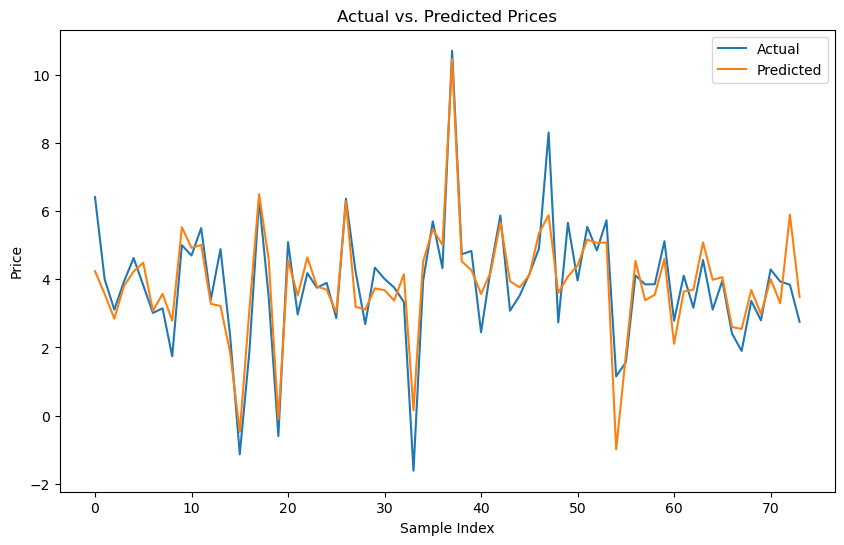

In [63]:
import matplotlib.pyplot as plt

# Convert the actual and predicted values to their original scale
y_val_original = scaler.inverse_transform(y_val)
y_val_pred_original = scaler.inverse_transform(y_val_pred)

# Define the step size for plotting
step = 100

# Plotting the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_val_original[::step], label='Actual')
plt.plot(y_val_pred_original[::step], label='Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Prices')
plt.legend()
plt.show()


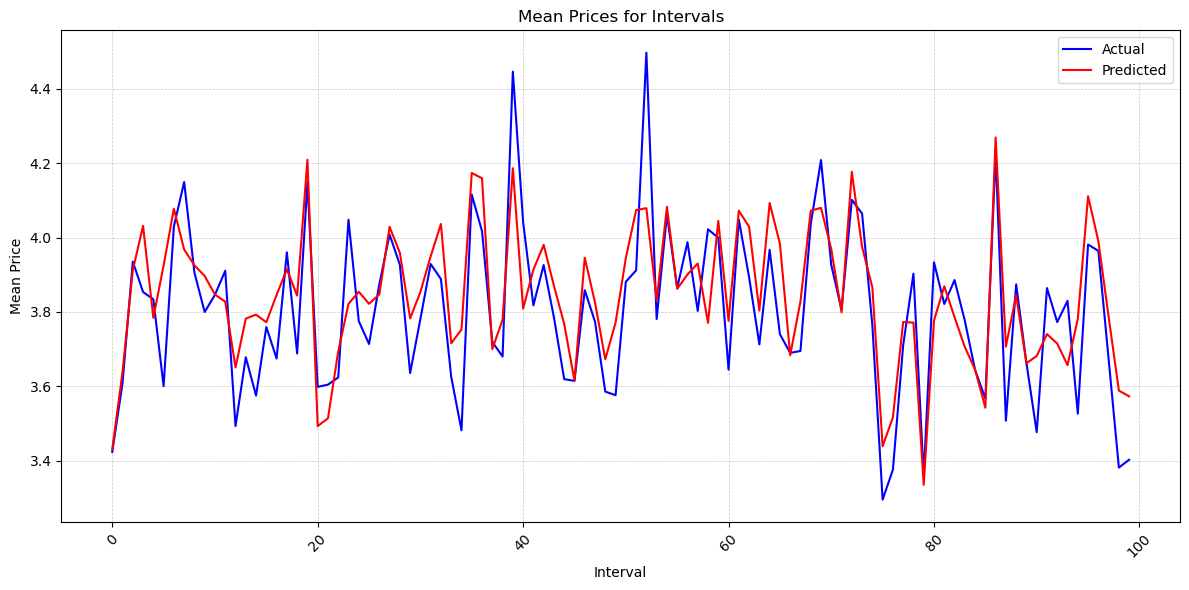

In [64]:
# Define the number of intervals
num_intervals = 100

# Calculate the interval size
interval_size = len(y_val_original) // num_intervals

# Calculate the means for each interval
interval_means_actual = [np.mean(y_val_original[i * interval_size:(i + 1) * interval_size]) for i in range(num_intervals)]
interval_means_pred = [np.mean(y_val_pred_original[i * interval_size:(i + 1) * interval_size]) for i in range(num_intervals)]

# Generate x-axis values for the intervals
x_values = np.arange(num_intervals)

# Plotting the interval means
plt.figure(figsize=(12, 6))
plt.plot(x_values, interval_means_actual, label='Actual', color='blue')
plt.plot(x_values, interval_means_pred, label='Predicted', color='red')
plt.xlabel('Interval')
plt.ylabel('Mean Price')
plt.title('Mean Prices for Intervals')
plt.legend()

# Customize the appearance of the plot
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()